In [5]:
run_name = "three neurons, 80 Dense"
description = "Increased the number of neurons in the hidden layer to 80"
data_version = "0" # only to tell IDE that version is a viable
%store -r data_version
# data_version = "dv1" # if you want to force a specific version

data_classes = ["Sniffing", "Background", "Quiet"]
correct_class_imbalance = True
epochs = 200
validation_fraction = 0.2

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
import tensorflow_io as tfio
import tensorflow.experimental.numpy as tnp
from tensorflow.python.ops import gen_audio_ops as audio_ops
import os
import mlflow
#  enable NumPy behavior for TensorFlow:
tnp.experimental_enable_numpy_behavior()

In [13]:
def generate_spectrogram(file_path, label):
    # does not scale as sniffing should be the same independent of background level
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype=tf.int16)
    audio = tf.cast(audio_tensor[:], tf.float32)
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True)
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    # Not sure whether the log is a good idea...
    spectrogram = tnp.log10(spectrogram + 1e-6)
    return spectrogram, label

def prepare_data(dir, value):
    filePath = os.path.join(dir, "*.wav")
    files = tf.data.Dataset.list_files(filePath)
    file_count = len(files)
    #values = tf.zeros(len(files)) if value == 0 else tf.ones(len(files))
    # First neuron for Sniffing
    if value == 0:
        values = tf.concat([tf.ones(shape=[file_count, 1]), tf.zeros(shape=[file_count, 1]), tf.zeros(shape=[file_count, 1])], axis=1)
    elif value == 1:
        values = tf.concat([tf.zeros(shape=[file_count, 1]), tf.ones(shape=[file_count, 1]), tf.zeros(shape=[file_count, 1])], axis=1)
    elif value == 2:
        values = tf.concat([tf.zeros(shape=[file_count, 1]), tf.zeros(shape=[file_count, 1]), tf.ones(shape=[file_count, 1])], axis=1)

    data = tf.data.Dataset.zip((files, tf.data.Dataset.from_tensor_slices(values)))
    spectrogramData = data.map(generate_spectrogram)
    return spectrogramData

def generate_dataset(train_or_test, classes):
    class_counts = []
    data_sets = []
    for index, current_class in enumerate(classes):
        current_data_dir = f"data/{train_or_test}/{current_class}"
        current_data = prepare_data(current_data_dir, index)
        data_sets.append(current_data)
        current_number = current_data.cardinality().numpy()
        class_counts.append(current_number)
        print(f"{current_class} Datasets: {current_number}")

    if correct_class_imbalance:
        smallest_data_count = min(class_counts)
        for index, data_set in enumerate(data_sets):
            corrected_data = data_set.shuffle(class_counts[index]).take(smallest_data_count)
            data_sets[index] = corrected_data
            corrected_number = corrected_data.cardinality().numpy()
            print(f"Corrected {classes[index]} Datasets: {corrected_number}")
    combined_data = data_sets[0]
    for next_data in data_sets[1:]:
        combined_data = combined_data.concatenate(next_data)
    combined_data = combined_data.cache()
    return combined_data.shuffle(buffer_size=combined_data.cardinality().numpy())

def split_validation(allData, fraction):
    numberDataSets = allData.cardinality().numpy()
    validationCount = round(numberDataSets * fraction)
    trainSet = allData.take(numberDataSets - validationCount)
    validationSet = allData.skip(numberDataSets - validationCount).take(validationCount)
    return trainSet, validationSet

def batch_prefetch(dataSet):
    dataSet = dataSet.batch(16)
    dataSet = dataSet.prefetch(8)
    return dataSet

def representative_data_gen():
    repr_samples, repr_labels = train.as_numpy_iterator().next()
    yield [repr_samples]

In [12]:
data = generate_dataset("train", data_classes)
train, validation = split_validation(data, validation_fraction)
train = batch_prefetch(train)
validation = batch_prefetch(validation)
samples, labels = train.as_numpy_iterator().next()
inputShape = samples.shape[1:]
print(f"inputShape {inputShape}")

Sniffing Datasets: 261
Background Datasets: 765
Quiet Datasets: 233
Corrected Sniffing Datasets: 233
Corrected Background Datasets: 233
Corrected Quiet Datasets: 233
inputShape (99, 43, 1)


In [15]:
# need the run id to log into same run over different cells
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id
    mlflow.tensorflow.autolog()
    mlflow.log_param("data_version", data_version)
    mlflow.log_param("data classes", data_classes)
    mlflow.log_param("validation fraction", validation_fraction)
    mlflow.log_param("correct class imbalance", correct_class_imbalance)
    mlflow.log_param("Description", description)

In [16]:
with mlflow.start_run(run_id=run_id, run_name=run_name) as run:
    model = Sequential([
        Conv2D(4, 3,
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(0.001),
               name='conv_layer1',
               input_shape=inputShape),
        MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
        Conv2D(4, 3,
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(0.001),
               name='conv_layer2'),
        MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
        Flatten(),
        Dropout(0.2),
        Dense(
            40,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001),
            name='hidden_layer1'
        ),
        Dense(
            3,
            activation='softmax',
            kernel_regularizer=regularizers.l2(0.001),
            name='output'
        )
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]])

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 49, 21, 4)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 4)         148       
                                                                 
 max_pooling2 (MaxPooling2D)  (None, 24, 10, 4)        0         
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 hidden_layer1 (Dense)       (None, 40)                3

In [17]:
with mlflow.start_run(run_id=run_id, run_name=run_name) as run:
    hist = model.fit(train, epochs=epochs, validation_data=validation)

Epoch 1/200
35/35 [==============================] - 9s 106ms/step - loss: 0.6858 - recall: 0.0948 - precision: 0.4690 - val_loss: 0.5994 - val_recall: 0.0857 - val_precision: 1.0000
Epoch 2/200
35/35 [==============================] - 2s 69ms/step - loss: 0.5511 - recall: 0.4275 - precision: 0.7177 - val_loss: 0.4918 - val_recall: 0.6500 - val_precision: 0.7712
Epoch 3/200
35/35 [==============================] - 2s 68ms/step - loss: 0.4761 - recall: 0.5921 - precision: 0.7103 - val_loss: 0.3919 - val_recall: 0.7286 - val_precision: 0.7846
Epoch 4/200
35/35 [==============================] - 2s 67ms/step - loss: 0.4258 - recall: 0.6601 - precision: 0.7193 - val_loss: 0.3932 - val_recall: 0.6857 - val_precision: 0.7742
Epoch 5/200
35/35 [==============================] - 2s 70ms/step - loss: 0.4114 - recall: 0.6905 - precision: 0.7311 - val_loss: 0.4229 - val_recall: 0.6214 - val_precision: 0.6304
Epoch 6/200
35/35 [==============================] - 3s 73ms/step - loss: 0.3920 - recall

INFO:tensorflow:Assets written to: C:\Users\Joerg\AppData\Local\Temp\tmpjbk49bt6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Joerg\AppData\Local\Temp\tmpjbk49bt6\model\data\model\assets
2023/04/08 09:09:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Joerg\anaconda3\envs\NeuralNetwork\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


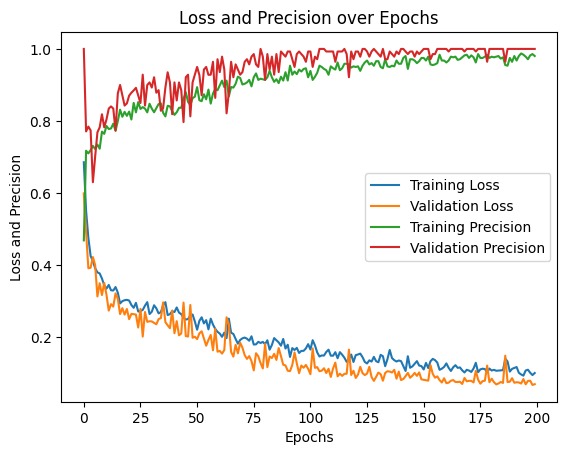

In [18]:
import matplotlib.pyplot as plt
with mlflow.start_run(run_id=run_id, run_name=run_name) as run:
    precision = list(hist.history.keys())[2]
    val_precision = list(hist.history.keys())[5]
    # Get the training loss and accuracy values from the history object
    training_loss = hist.history['loss']
    training_accuracy = hist.history[precision]

    # Get the validation loss and accuracy values from the history object
    validation_loss = hist.history['val_loss']
    validation_accuracy = hist.history[val_precision]

    # Plot the training and validation loss and accuracy on the same subplot
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.plot(training_accuracy, label='Training Precision')
    plt.plot(validation_accuracy, label='Validation Precision')
    plt.legend()
    plt.title('Loss and Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss and Precision')
    fig = plt.gcf()
    mlflow.log_figure(fig, 'Loss and Accuracy Plot.png')
    plt.show()

In [19]:
with mlflow.start_run(run_id=run_id, run_name=run_name) as run:
    testData = generate_dataset("test", data_classes)
    testData = batch_prefetch(testData)

    test_loss, test_recall, test_precision = model.evaluate(testData)
    mlflow.log_metric("Test Loss", test_loss)
    mlflow.log_metric("Test Precision", test_precision)

Sniffing Datasets: 54
Background Datasets: 199
Quiet Datasets: 47
Corrected Sniffing Datasets: 47
Corrected Background Datasets: 47
Corrected Quiet Datasets: 47
9/9 [==============================] - 3s 7ms/step - loss: 0.4490 - recall: 0.7943 - precision: 0.7943


In [20]:
mlflow.end_run()